# 缺陷波导光子晶体能带仿真以及透射率验证

Date: 2023 12 16

## 计算模型简介

来源于下面的这个问题：
https://github.com/NanoComp/meep/discussions/2705

具体结构时：
>材料是铌酸锂，是线缺陷光子晶体板，周期是0.775um，高为0.3um，孔半径是0.315倍的周期，50个周期长度，两边空排数为4排，上下都是空气

## 能带计算

In [1]:
import meep as mp
import meep.mpb as mpb
from matplotlib import pyplot as plt
import numpy as np
import argparse

# 色散曲线
def lno(a):
    b = 1+2.6734*a**2/(a**2-0.01764)+1.2290*a**2/(a**2-0.0591)+12.614*a**2/(a**2-474.60)
    return b
def lne(a):
    b = 1+2.9804*a**2/(a**2-0.02047)+0.5981*a**2/(a**2-0.0666)+8.9543*a**2/(a**2-416.08)
    return b
def add_cylinder(local,r,h):
    a = mp.Cylinder(radius=r,height=h,center=local,material=mp.air)
    return a
def main(args):
    a = args.a
    m = args.m
    n = args.n
    r,h = m*a,0.3
    r = r/a
    h = h/a
    y_num = args.y_num
    resolution = args.resolution
    wavelength = args.wavelength
    LN = mp.Medium(epsilon_diag=(lno(wavelength),lno(wavelength),lne(wavelength)))
    supercell_y = y_num*2+1
    Lattice_size = mp.Vector3(1,supercell_y,5)
    Lattice_size_copy = mp.Vector3(1,supercell_y,0)
    geometry_lattic = mp.Lattice(size=Lattice_size,
                                 basis1=mp.Vector3(np.sqrt(3)*0.5,0.5),
                                 basis2=mp.Vector3(np.sqrt(3)*0.5,-0.5))
    geometry_lattic_copy = mp.Lattice(size=Lattice_size_copy,
                                 basis1=mp.Vector3(np.sqrt(3)*0.5,0.5),
                                 basis2=mp.Vector3(np.sqrt(3)*0.5,-0.5))
    geometry = [mp.Block(size=mp.Vector3(mp.inf,mp.inf,h),center=mp.Vector3(),material=LN,
                         e1=mp.cartesian_to_lattice(mp.Vector3(1,0,0),geometry_lattic),
                         e2=mp.cartesian_to_lattice(mp.Vector3(0,1,0),geometry_lattic),
                         e3=mp.cartesian_to_lattice(mp.Vector3(0,0,1),geometry_lattic)),]
    geometry_cylinder = [mp.Cylinder(radius=r,height=mp.inf,material=mp.air)]
    geometry += mp.geometric_objects_lattice_duplicates(geometry_lattic_copy,geometry_cylinder)
    geometry += [mp.Cylinder(radius=r,height=h,material=LN)]
    
    num_band = args.num_band
    num_k = args.num_k
    k_start = args.k_start
    Gamma = mp.Vector3(x=k_start)
    k_end = args.k_end
    K_prime = mp.lattice_to_reciprocal(mp.Vector3(k_end),geometry_lattic)
    k_points = mp.interpolate(num_k,[Gamma,K_prime])
    ms = mpb.ModeSolver(resolution=resolution,
                        geometry_lattice=geometry_lattic,
                        geometry=geometry,
                        k_points=k_points,
                        num_bands=num_band)
    run_mode = args.run_mode
    if run_mode == 'yeven_zeven':
        ms.run_yeven_zeven()
    elif run_mode =='yodd_zeven':
        ms.run_yodd_zeven()
    elif run_mode =='yeven_zodd':
        ms.run_yeven_zodd()
    elif run_mode =='yodd_zodd':
        ms.run_yodd_zodd()
    elif run_mode =='tm':
        ms.run_tm()
    elif run_mode == 'te':
        ms.run_te()
    freq = ms.all_freqs
#     for i in range(freq.shape[0]):
#         for j in range(num_band):
#             if freq[:,0:][0:freq.shape[0],:][i][j] > np.linspace(k_start,k_end,freq.shape[0])[i]:
#                 freq[:,0:][0:freq.shape[0],:][i][j] = np.linspace(k_start,k_end,freq.shape[0])[i]
#     plt.grid(True)
#     plt.xlim(k_start,k_end)
#     plt.plot(np.linspace(k_start,k_end,freq.shape[0]),freq[:,0:],'r-')
#     plt.plot(np.linspace(k_start,k_end,freq.shape[0]),np.linspace(k_start,k_end,freq.shape[0]),'b-')
#     name = args.name
#     plt.savefig(name)
    
    return freq

/home/tzh/miniconda3/envs/mp/lib/python3.11/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/tzh/miniconda3/envs/mp/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/tzh/miniconda3/envs/mp/lib/python3.11/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/tzh/miniconda3/envs/mp/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
# parse = argparse.ArgumentParser() For terminal use
parse = argparse.ArgumentParser()
parse.add_argument('-a',type=float,default=0.775)
parse.add_argument('-m',type=float,default=0.315)
parse.add_argument('-n',type=float,default=0)
parse.add_argument('-wavelength',type=float,default=1.55)
parse.add_argument('-k_start',type=float,default=0)
parse.add_argument('-k_end',type=float,default=0.5)
parse.add_argument('-y_num',type=int,default=5)
parse.add_argument('-resolution',type=int,default=10)
parse.add_argument('-num_k',type=int,default=10)
parse.add_argument('-num_band',type=int,default=30)
parse.add_argument('-run_mode',type=str,default='yodd_zeven')
parse.add_argument('-name',type=str,default='yodd_zeven.png')
args = parse.parse_args(args=[]) 
# args = parse.parse_args()  For terminal use
freq=main(args)

Initializing eigensolver data
Computing 30 bands with 1e-07 tolerance
Working in 3 dimensions.
Grid size is 10 x 112 x 50.
Solving for 10 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (0.866025, 0.5, 0)
     (9.52628, -5.5, 0)
     (0, 0, 5)
Cell volume = 47.6314
Reciprocal lattice vectors (/ 2 pi):
     (0.57735, 1, -0)
     (0.0524864, -0.0909091, 0)
     (-0, 0, 0.2)
Geometric objects:
     block, center = (0,0,0)
          size (1e+20,1e+20,0.387097)
          axes (0.57735,0.57735,0), (1,-1,0), (0,0,1)
     cylinder, center = (0,5,0)
          radius 0.315, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0,4,0)
          radius 0.315, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0,3,0)
          radius 0.315, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0,2,0)
          radius 0.315, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0,1,0)
          radius 0.315, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0,0

    linmin: converged after 4 iterations.
    iteration   24: trace = 1.669229420310631 (0.00128914% change)
    linmin: converged after 3 iterations.
    iteration   25: trace = 1.669217187527519 (0.000732843% change)
    linmin: converged after 3 iterations.
    iteration   26: trace = 1.669208788059203 (0.000503199% change)
    linmin: converged after 3 iterations.
    iteration   27: trace = 1.669202192770548 (0.000395115% change)
    linmin: converged after 3 iterations.
    iteration   28: trace = 1.669196430523852 (0.00034521% change)
    linmin: converged after 3 iterations.
    iteration   29: trace = 1.669191071139057 (0.000321076% change)
    linmin: converged after 4 iterations.
    iteration   30: trace = 1.669185982513814 (0.000304856% change)
    linmin: converged after 4 iterations.
    iteration   31: trace = 1.669181149335862 (0.000289553% change)
    linmin: converged after 5 iterations.
    iteration   32: trace = 1.669176572668279 (0.000274187% change)
    linmin: 

    iteration   13: trace = 2.668725798633381 (0.0188425% change)
    linmin: converged after 4 iterations.
    iteration   14: trace = 2.668445591375395 (0.0105002% change)
    linmin: converged after 4 iterations.
    iteration   15: trace = 2.668299508059965 (0.00547462% change)
    linmin: converged after 4 iterations.
    iteration   16: trace = 2.668197755135889 (0.00381347% change)
    linmin: converged after 4 iterations.
    iteration   17: trace = 2.668140998307218 (0.00212718% change)
    linmin: converged after 4 iterations.
    iteration   18: trace = 2.668105853547876 (0.00131721% change)
    linmin: converged after 4 iterations.
    iteration   19: trace = 2.668083064987356 (0.000854114% change)
    linmin: converged after 4 iterations.
    iteration   20: trace = 2.66806733389349 (0.000589605% change)
    linmin: converged after 4 iterations.
    iteration   21: trace = 2.668057074941468 (0.000384509% change)
    linmin: converged after 4 iterations.
    iteration   22:

    linmin: converged after 4 iterations.
    iteration   38: trace = 0.2852515844870261 (0.136926% change)
    linmin: converged after 4 iterations.
    iteration   39: trace = 0.2849324886065042 (0.111927% change)
    linmin: converged after 4 iterations.
    iteration   40: trace = 0.2846253037653129 (0.107868% change)
    linmin: converged after 4 iterations.
    iteration   41: trace = 0.2843092305013977 (0.111111% change)
    linmin: converged after 4 iterations.
    iteration   42: trace = 0.2841135605851664 (0.0688466% change)
    linmin: converged after 3 iterations.
    iteration   43: trace = 0.2840501450446486 (0.022323% change)
    linmin: converged after 3 iterations.
    iteration   44: trace = 0.2840256474614248 (0.00862476% change)
    linmin: converged after 2 iterations.
    iteration   45: trace = 0.2840174345451098 (0.00289165% change)
    linmin: converged after 4 iterations.
    iteration   46: trace = 0.2840118184221247 (0.00197741% change)
    linmin: converged

    linmin: converged after 3 iterations.
    iteration   52: trace = 0.8118176058610839 (0.00205484% change)
    large trace change predicted (0.00596488%)
    linmin: converged after 5 iterations.
    iteration   53: trace = 0.811773946534212 (0.00537812% change)
    linmin: converged after 4 iterations.
    iteration   54: trace = 0.8117271075377861 (0.00577012% change)
    linmin: converged after 4 iterations.
    iteration   55: trace = 0.8116887512029776 (0.00472539% change)
    linmin: converged after 3 iterations.
    iteration   56: trace = 0.8116674615939221 (0.00262291% change)
    linmin: converged after 3 iterations.
    iteration   57: trace = 0.8116570299336945 (0.00128522% change)
    linmin: converged after 3 iterations.
    iteration   58: trace = 0.8116532158222781 (0.000469918% change)
    linmin: converged after 2 iterations.
    iteration   59: trace = 0.8116517940461228 (0.000175171% change)
    linmin: converged after 2 iterations.
    iteration   60: trace = 0.

    iteration    3: trace = 0.8596832032810707 (0.00226221% change)
    linmin: converged after 2 iterations.
    iteration    4: trace = 0.8596774729510532 (0.000666565% change)
    linmin: converged after 2 iterations.
    iteration    5: trace = 0.859675398420651 (0.000241315% change)
    linmin: converged after 2 iterations.
    iteration    6: trace = 0.8596748006758013 (6.95315e-05% change)
    linmin: converged after 2 iterations.
    iteration    7: trace = 0.8596745524783145 (2.88711e-05% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 0.8596744436908554 (1.26545e-05% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 0.8596743687944641 (8.71218e-06% change)
Finished solving for bands 11 to 20 after 9 iterations.
Solving for bands 21 to 30...
    linmin: converged after 4 iterations.
    iteration    1: trace = 1.406138788932817 (0.353829% change)
    linmin: converged after 2 iterations.
    iteration    2: trace = 1.40

    large trace change predicted (0.0415093%)
    linmin: converged after 4 iterations.
    iteration   70: trace = 0.5349349126801085 (0.0415473% change)
    linmin: converged after 4 iterations.
    iteration   71: trace = 0.5348732688904606 (0.0115243% change)
    linmin: converged after 4 iterations.
    iteration   72: trace = 0.5348475951141463 (0.00480009% change)
    linmin: converged after 2 iterations.
    iteration   73: trace = 0.5348376283000412 (0.0018635% change)
    linmin: converged after 2 iterations.
    iteration   74: trace = 0.534833210250415 (0.000826058% change)
    linmin: converged after 2 iterations.
    iteration   75: trace = 0.534829817061363 (0.000634441% change)
    linmin: converged after 2 iterations.
    iteration   76: trace = 0.5348289882313109 (0.000154971% change)
    linmin: converged after 2 iterations.
    iteration   77: trace = 0.5348287010114006 (5.37031e-05% change)
    linmin: converged after 2 iterations.
    iteration   78: trace = 0.534

    linmin: converged after 2 iterations.
    iteration   10: trace = 1.195691992708101 (0.000136353% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 1.195691556419696 (3.64884e-05% change)
    linmin: converged after 2 iterations.
    iteration   12: trace = 1.195691354020139 (1.69274e-05% change)
    linmin: converged after 2 iterations.
    iteration   13: trace = 1.195691244423534 (9.16596e-06% change)
Finished solving for bands 11 to 20 after 13 iterations.
Solving for bands 21 to 30...
    linmin: converged after 4 iterations.
    iteration    1: trace = 1.771069666978208 (0.148709% change)
    linmin: converged after 4 iterations.
    iteration    2: trace = 1.770681839162567 (0.0219003% change)
    linmin: converged after 2 iterations.
    iteration    3: trace = 1.770607958622738 (0.00417252% change)
    linmin: converged after 2 iterations.
    iteration    4: trace = 1.770581692632203 (0.00148346% change)
    linmin: converged after 2 iterations

    large trace change predicted (0.00953206%)
    linmin: converged after 5 iterations.
    iteration   29: trace = 1.36469527002123 (0.0059742% change)
    linmin: converged after 5 iterations.
    iteration   30: trace = 1.364617897532203 (0.00566974% change)
    linmin: converged after 4 iterations.
    iteration   31: trace = 1.364555101135211 (0.00460186% change)
    linmin: converged after 3 iterations.
    iteration   32: trace = 1.364494988671254 (0.00440538% change)
    linmin: converged after 4 iterations.
    iteration   33: trace = 1.364432936167191 (0.00454776% change)
    linmin: converged after 4 iterations.
    iteration   34: trace = 1.364366882880781 (0.0048412% change)
    linmin: converged after 4 iterations.
    iteration   35: trace = 1.364296695645761 (0.00514444% change)
    linmin: converged after 4 iterations.
    iteration   36: trace = 1.364224130932176 (0.00531898% change)
    linmin: converged after 4 iterations.
    iteration   37: trace = 1.364152438378

    large trace change predicted (0.00014921%)
    linmin: converged after 3 iterations.
    iteration   23: trace = 1.968307625767 (0.000148804% change)
    large trace change predicted (0.00194299%)
    linmin: converged after 4 iterations.
    iteration   24: trace = 1.968285788787598 (0.00110944% change)
    large trace change predicted (0.00388926%)
    linmin: converged after 6 iterations.
    iteration   25: trace = 1.968257971345839 (0.00141329% change)
    linmin: converged after 4 iterations.
    iteration   26: trace = 1.968241036440323 (0.000860404% change)
    linmin: converged after 3 iterations.
    iteration   27: trace = 1.968225721394527 (0.000778111% change)
    linmin: converged after 4 iterations.
    iteration   28: trace = 1.968209520606963 (0.00082312% change)
    linmin: converged after 3 iterations.
    iteration   29: trace = 1.968190687847114 (0.000956852% change)
    linmin: converged after 3 iterations.
    iteration   30: trace = 1.968168537983236 (0.0011

    linmin: converged after 2 iterations.
    iteration   71: trace = 1.03182381379665 (0.00555509% change)
    linmin: converged after 4 iterations.
    iteration   72: trace = 1.031775374943499 (0.0046946% change)
    linmin: converged after 4 iterations.
    iteration   73: trace = 1.031748432179299 (0.00261134% change)
    linmin: converged after 2 iterations.
    iteration   74: trace = 1.031730351539372 (0.00175244% change)
    linmin: converged after 4 iterations.
    iteration   75: trace = 1.031715746144626 (0.00141563% change)
    linmin: converged after 4 iterations.
    iteration   76: trace = 1.031702484779589 (0.00128538% change)
    linmin: converged after 2 iterations.
    iteration   77: trace = 1.031676555960128 (0.00251324% change)
    linmin: converged after 4 iterations.
    iteration   78: trace = 1.031652356511571 (0.00234567% change)
    linmin: converged after 4 iterations.
    iteration   79: trace = 1.031628519417504 (0.0023106% change)
    linmin: converged 

    linmin: converged after 3 iterations.
    iteration   45: trace = 2.172259681490051 (0.000660464% change)
    linmin: converged after 3 iterations.
    iteration   46: trace = 2.172246724919609 (0.000596458% change)
    linmin: converged after 3 iterations.
    iteration   47: trace = 2.172235934902921 (0.000496723% change)
    linmin: converged after 2 iterations.
    iteration   48: trace = 2.172226643614938 (0.00042773% change)
    linmin: converged after 2 iterations.
    iteration   49: trace = 2.172218275088345 (0.000385252% change)
    linmin: converged after 4 iterations.
    iteration   50: trace = 2.172211167995509 (0.000327182% change)
    linmin: converged after 2 iterations.
    iteration   51: trace = 2.172206016270954 (0.000237165% change)
    linmin: converged after 2 iterations.
    iteration   52: trace = 2.172202712348938 (0.0001521% change)
    linmin: converged after 2 iterations.
    iteration   53: trace = 2.172200522099047 (0.000100831% change)
    linmin: c

    iteration    4: trace = 2.401056148531778 (0.243299% change)
    linmin: converged after 3 iterations.
    iteration    5: trace = 2.397766211132368 (0.137114% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 2.39665818169988 (0.0462216% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 2.396303137964026 (0.0148152% change)
    linmin: converged after 4 iterations.
    iteration    8: trace = 2.396073172419888 (0.00959714% change)
    linmin: converged after 4 iterations.
    iteration    9: trace = 2.395961549127036 (0.0046587% change)
    linmin: converged after 4 iterations.
    iteration   10: trace = 2.395892614513976 (0.00287716% change)
    linmin: converged after 4 iterations.
    iteration   11: trace = 2.395830001982442 (0.00261336% change)
    linmin: converged after 4 iterations.
    iteration   12: trace = 2.395753846348739 (0.00317872% change)
    linmin: converged after 3 iterations.
    iteration   13: trace =

    linmin: converged after 4 iterations.
    iteration    8: trace = 1.992740370654433 (0.00336785% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 1.992711579506175 (0.00144481% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 1.992686154127304 (0.00127593% change)
    linmin: converged after 4 iterations.
    iteration   11: trace = 1.992652076403948 (0.00171015% change)
    large trace change predicted (0.00356521%)
    linmin: converged after 3 iterations.
    iteration   12: trace = 1.992581263166463 (0.00355378% change)
    large trace change predicted (0.0130692%)
    linmin: converged after 4 iterations.
    iteration   13: trace = 1.992344666469826 (0.0118746% change)
    large trace change predicted (0.0288125%)
    linmin: converged after 4 iterations.
    iteration   14: trace = 1.99185923957637 (0.0243676% change)
    linmin: converged after 4 iterations.
    iteration   15: trace = 1.991360335178033 (0.0250503% c

    iteration   13: trace = 1.443145448281363 (0.000653972% change)
    linmin: converged after 4 iterations.
    iteration   14: trace = 1.443140727693578 (0.000327105% change)
    linmin: converged after 2 iterations.
    iteration   15: trace = 1.443138705531295 (0.000140122% change)
    linmin: converged after 2 iterations.
    iteration   16: trace = 1.443137379817008 (9.18633e-05% change)
    linmin: converged after 2 iterations.
    iteration   17: trace = 1.443136523456529 (5.93402e-05% change)
    linmin: converged after 2 iterations.
    iteration   18: trace = 1.443135868356442 (4.53942e-05% change)
    linmin: converged after 2 iterations.
    iteration   19: trace = 1.443135445175955 (2.93237e-05% change)
    linmin: converged after 2 iterations.
    iteration   20: trace = 1.443135217361864 (1.57861e-05% change)
    linmin: converged after 2 iterations.
    iteration   21: trace = 1.443135124557426 (6.43075e-06% change)
Finished solving for bands 1 to 10 after 21 iteratio

    linmin: converged after 3 iterations.
    iteration   66: trace = 2.220688409116904 (0.00113948% change)
    linmin: converged after 3 iterations.
    iteration   67: trace = 2.220663401234667 (0.00112614% change)
    linmin: converged after 3 iterations.
    iteration   68: trace = 2.220641109896017 (0.00100382% change)
    linmin: converged after 3 iterations.
    iteration   69: trace = 2.220622360178347 (0.000844342% change)
    resetting CG direction...
    large trace change predicted (0.00190209%)
    linmin: converged after 2 iterations.
    iteration   70: trace = 2.220580113280678 (0.0019025% change)
    linmin: converged after 2 iterations.
    iteration   71: trace = 2.220540446860729 (0.00178632% change)
    linmin: converged after 2 iterations.
    iteration   72: trace = 2.220514174159696 (0.00118317% change)
    linmin: converged after 2 iterations.
    iteration   73: trace = 2.220493545485841 (0.000929009% change)
    linmin: converged after 2 iterations.
    iter

    linmin: converged after 2 iterations.
    iteration   45: trace = 2.658571563046505 (2.20739e-05% change)
    linmin: converged after 2 iterations.
    iteration   46: trace = 2.658571062225192 (1.8838e-05% change)
    linmin: converged after 2 iterations.
    iteration   47: trace = 2.658570526100851 (2.01659e-05% change)
    linmin: converged after 2 iterations.
    iteration   48: trace = 2.658569985573201 (2.03315e-05% change)
    linmin: converged after 2 iterations.
    iteration   49: trace = 2.65856941879577 (2.13189e-05% change)
    linmin: converged after 2 iterations.
    iteration   50: trace = 2.658568796849268 (2.3394e-05% change)
    linmin: converged after 2 iterations.
    iteration   51: trace = 2.658568267015594 (1.99293e-05% change)
    linmin: converged after 2 iterations.
    iteration   52: trace = 2.658567842270107 (1.59765e-05% change)
    linmin: converged after 2 iterations.
    iteration   53: trace = 2.658567449745742 (1.47645e-05% change)
    linmin: c

    linmin: converged after 2 iterations.
    iteration   60: trace = 1.472798229408813 (4.5099e-05% change)
    linmin: converged after 2 iterations.
    iteration   61: trace = 1.472797959284799 (1.83409e-05% change)
    linmin: converged after 2 iterations.
    iteration   62: trace = 1.472797827676041 (8.93597e-06% change)
Finished solving for bands 1 to 10 after 62 iterations.
Solving for bands 11 to 20...
    linmin: converged after 5 iterations.
    iteration    1: trace = 2.56184442449242 (1.89263% change)
    large trace change predicted (6.77515%)
    linmin: converged after 5 iterations.
    iteration    2: trace = 2.487222815428045 (2.95586% change)
    linmin: converged after 6 iterations.
    iteration    3: trace = 2.449392008937254 (1.53266% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 2.436225283554276 (0.538999% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 2.422652028166976 (0.558699% change)
    linmin

    iteration    1: trace = 3.001578547829827 (4.81926% change)
    linmin: converged after 5 iterations.
    iteration    2: trace = 2.944561112761999 (1.9178% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 2.922721359365863 (0.744459% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 2.910175350158481 (0.430181% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 2.89790620285758 (0.422485% change)
    linmin: converged after 5 iterations.
    iteration    6: trace = 2.877602674042364 (0.703091% change)
    linmin: converged after 5 iterations.
    iteration    7: trace = 2.848542402489405 (1.015% change)
    linmin: converged after 6 iterations.
    iteration    8: trace = 2.828159180096543 (0.718136% change)
    linmin: converged after 5 iterations.
    iteration    9: trace = 2.813266971997647 (0.527959% change)
    linmin: converged after 5 iterations.
    iteration   10: trace = 2.8033401197237 

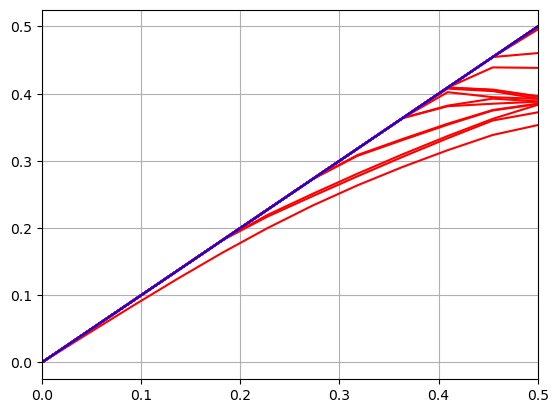

In [7]:
num_band=30
k_start=0
k_end=0.5
for i in range(freq.shape[0]):
    for j in range(num_band):
        if freq[:,0:][0:freq.shape[0],:][i][j] > np.linspace(k_start,k_end,freq.shape[0])[i]:
            freq[:,0:][0:freq.shape[0],:][i][j] = np.linspace(k_start,k_end,freq.shape[0])[i]
plt.grid(True)
plt.xlim(k_start,k_end)
plt.plot(np.linspace(k_start,k_end,freq.shape[0]),freq[:,0:],'r-')
plt.plot(np.linspace(k_start,k_end,freq.shape[0]),np.linspace(k_start,k_end,freq.shape[0]),'b-')
# name = args.name
# plt.savefig(name)

得到的能带分布如上图所示，也可以将纵坐标转化为波长，现在总坐标为$\nu=\omega/(2\pi)a$,如果是实际的波长，则
$$\lambda=c/\nu$$

## 投射系数计算
然后计算透射系数，此时输入源设置为平面波

In [18]:
import numpy as np
import meep as mp
import matplotlib.pyplot as plt
import argparse

# 各向异性系数
def lno(a):
    b = 1+2.6734*a**2/(a**2-0.01764)+1.2290*a**2/(a**2-0.0591)+12.614*a**2/(a**2-474.60)
    return b
def lne(a):
    b = 1+2.9804*a**2/(a**2-0.02047)+0.5981*a**2/(a**2-0.0666)+8.9543*a**2/(a**2-416.08)
    return b

def add_cylinder(local,r,h):
    a = mp.Cylinder(radius=r,height=h,center=local,material=mp.air)
    return a

def main(args):
    a = args.a
    m = args.m
    r,h = m*a,0.3
    x_num = args.x_num # x方向周期数
    y_num = args.y_num # y方向周期数
    period_num = args.period_num #传播方向周期数
    resolution = args.resolution # 分辨率
    pml_h = args.pml_h # PML厚度
    field_decay = args.field_decay # 衰减系数
    wg_weight = y_num*np.sqrt(3)*a*2 #波导宽度
    
    lambda_min = args.lambda_min # 最短波长
    lambda_max = args.lambda_max # 最长波长
    nfreq = args.nfreq # 频率数
    fcen = 0.5*(1/lambda_max+1/lambda_min) # 中心频率
    df = 1/lambda_min-1/lambda_max # 频谱宽度
    LN = mp.Medium(epsilon_diag=(lno(1/fcen),lno(1/fcen),lne(1/fcen))) # 材料
    
    block_x,block_y,block_z=0,0,0
    Block_x,Block_y,Block_z=x_num*a,wg_weight,h #设置波导
    
    x_length = 6  # x区域宽度
    y_length = np.sqrt(3)*a # y区域宽度
    z_length = h # 高度
    block_x1= -x_num*0.5*a-x_length*0.5 # 水平坐标最小
    block_x2= -block_x1 # 水平坐标最大
    
    soc_wight,soc_hight=np.sqrt(3)*a*2,3*h # 源计算区域的宽度、高度
    soc_area=mp.Vector3(0,soc_wight,soc_hight) # 源计算区域，波导沿着x传播
    soc_local=mp.Vector3(-0.5*a*x_num-x_length*0.9,0,0) # 源的中心位置
#     eig_sources = [mp.EigenModeSource(
#         src=mp.GaussianSource(fcen,fwidth=df),
#         center=soc_local,
#         direction=mp.AUTOMATIC,
#         size=soc_area,
#         eig_band=1,
#         eig_kpoint=mp.Vector3(1,0,0),
#         eig_parity=mp.EVEN_Z+mp.ODD_Y,
#         eig_match_freq=True,
#         )]
    # 设置源是高斯波包的源
    sources = [mp.Source(mp.GaussianSource(fcen, fwidth=df),
                         center=soc_local,
                         size=soc_area,
                         component=mp.Ex)]# 设置Ey
    symmetry=[mp.Mirror(mp.Z,phase=1),mp.Mirror(mp.Y,phase=-1)]# 对称性
    
    monitor_size=soc_area+soc_area# 监视器大小
    monitor_1_local=mp.Vector3(x=-period_num*0.5*a)# 位置1
    monitor_2_local=mp.Vector3(x=period_num*a*0.5)# 位置2
    monitor_3_local=mp.Vector3(x=a)+soc_local#stright refl
    monitor_4_local=mp.Vector3(x=a)+monitor_1_local#phc_wg refl
    monitor_5_local=mp.Vector3(x=y_num*a*np.sqrt(3)*0.5-0.1*a)#stright tran
  
    sim_x,sim_y,sim_z=x_num*a+2*x_length+pml_h*2,y_num*a*np.sqrt(3)+pml_h*2,10*h+pml_h*2 # 计算区域
    sim_area=mp.Vector3(sim_x,sim_y,sim_z) 
    
    # 单个原胞的结构
    geo_phc = [mp.Block(size=mp.Vector3(Block_x,Block_y,Block_z),center = mp.Vector3(),
                        material = LN),
               mp.Block(size=mp.Vector3(x_length,y_length,z_length),
                          center=mp.Vector3(block_x1,0,0),
                          material=LN),
                mp.Block(size=mp.Vector3(x_length,y_length,z_length),
                          center=mp.Vector3(block_x2,0,0),
                          material=LN)]
    for i in np.linspace(-x_num*0.5*a,x_num*0.5*a,70+1):
        for j in np.linspace(-y_num*np.sqrt(3)*a,y_num*np.sqrt(3)*a,2*y_num+1):
            if float('%.9f'%j) != 0:
                geo_phc += [add_cylinder(mp.Vector3(i+0.5*a,j,0),r,h),
                            add_cylinder(mp.Vector3(i,j+np.sqrt(3)*0.5*a,0),r,h)]
            else:
                geo_phc += [add_cylinder(mp.Vector3(i,np.sqrt(3)*0.5*a,0),r,h)]
    geo_str = [mp.Block(size=mp.Vector3(sim_x,y_length,z_length),
                         center=mp.Vector3(0),
                         material=LN)]
    
    sim = mp.Simulation(cell_size=sim_area,
                        resolution=resolution,
                        boundary_layers=[mp.PML(pml_h)],
                        sources=sources,
                        geometry=geo_str,
                        symmetries=symmetry)
    refl_str=sim.add_flux(fcen,df,nfreq,
                  mp.FluxRegion(center=monitor_3_local,direction=mp.X,size=monitor_size))
    tran_str=sim.add_flux(fcen,df,nfreq,
                   mp.FluxRegion(center=monitor_5_local,direction=mp.X,size=monitor_size))
    pt=monitor_5_local-mp.Vector3(x=0.5*a)
    sim.run(until_after_sources=mp.stop_when_fields_decayed(50,mp.Ey,pt,field_decay))
    str_tran_flux = mp.get_fluxes(tran_str)
    str_refl_data=sim.get_flux_data(refl_str)
    
    sim.reset_meep()
    
    sim = mp.Simulation(cell_size=sim_area,
                        resolution=resolution,
                        boundary_layers=[mp.PML(pml_h)],
                        sources=sources,
                        geometry=geo_phc,
                        symmetries=symmetry,
                        force_complex_fields=True)
    refl_phc=sim.add_flux(fcen,df,nfreq,
                  mp.FluxRegion(center=monitor_3_local,direction=mp.X,size=monitor_size))
    tran_phc_1=sim.add_flux(fcen,df,nfreq,
                  mp.FluxRegion(center=monitor_1_local,direction=mp.X,size=monitor_size))
    tran_phc_2=sim.add_flux(fcen,df,nfreq,
                   mp.FluxRegion(center=monitor_2_local,direction=mp.X,size=monitor_size))
    sim.load_minus_flux_data(refl_phc,str_refl_data)
    pt=monitor_2_local-mp.Vector3(x=0.5*a)
    sim.run(until_after_sources=mp.stop_when_fields_decayed(50,mp.Ey,pt,field_decay))
    phc_tran_flux_1=mp.get_fluxes(tran_phc_1)
    phc_tran_flux_2=mp.get_fluxes(tran_phc_2)
    flux_freq=mp.get_flux_freqs(refl_phc)
    
    return phc_tran_flux_1,phc_tran_flux_2,flux_freq,nfreq
    
#     wl = []
#     Ts_1 = []
#     for i in range(nfreq):
#         wl = np.append(wl,1/flux_freq[i])
#         Ts_1 = np.append(Ts_1,phc_tran_flux_2[i]/phc_tran_flux_1[i])
#     plt.grid(True)
#     plt.plot(wl, Ts_1, "b*-", label="transmittance_1")
#     plt.xlim(min(wl),max(wl))
#     plt.xlabel("wavelength (μm)")
#     plt.legend(loc="best")
#     plt.savefig(args.name)
#     plt.show()
    
parse = argparse.ArgumentParser()
parse.add_argument('-a',type=float,default=0.775,)
parse.add_argument('-m',type=float,default=0.315,)
parse.add_argument('-pml_h',type=float,default=1,)
parse.add_argument('-x_num',type=int,default=60,)
parse.add_argument('-y_num',type=int,default=6,)
parse.add_argument('-period_num',type=int,default=50,)
parse.add_argument('-resolution',type=int,default=10,)
parse.add_argument('-lambda_min',type=float,default=1.5,)
parse.add_argument('-lambda_max',type=float,default=1.85,)
parse.add_argument('-nfreq',type=int,default=100,)
parse.add_argument('-field_decay',type=float,default=1e-6,)
parse.add_argument('-name',type=str,default='T_0.67_0.33_6.png',)
args = parse.parse_args(args=[]) 
phc_tran_flux_1,phc_tran_flux_2,flux_freq,nfreq=main(args)

-----------
Initializing structure...
Padding y to even number of grid points.
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00142694 s
Working in 3D dimensions.
Computational cell is 60.5 x 10.1 x 5 with resolution 10
     block, center = (0,0,0)
          size (60.5,1.34234,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.87336,4.87336,4.55631)
time for set_epsilon = 0.804897 s
-----------
on time step 174 (time=8.7), 0.0230512 s/step
on time step 426 (time=21.3), 0.015931 s/step
on time step 685 (time=34.25), 0.0154665 s/step
on time step 939 (time=46.95), 0.0157731 s/step
field decay(t = 50.050000000000004): 2.3177824489106053e-10 / 2.3177824489106053e-10 = 1.0
on time step 1197 (time=59.85), 0.0155634 s/step
on time step 1463 (time=73.15), 0.0150923 s/step
on time step 1724 (time=86.2), 0.0153414 s/step
on time step 1987 (time=99.35), 0.0152627 s/step
fiel

field decay(t = 200.15): 1.5829091283806265e-08 / 0.04542118724937414 = 3.4849576249296244e-07
run 0 finished at t = 200.15 (4003 timesteps)
-----------
Initializing structure...
Padding y to even number of grid points.
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00338101 s
Working in 3D dimensions.
Computational cell is 60.5 x 10.1 x 5 with resolution 10
     block, center = (0,0,0)
          size (46.5,16.1081,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.87336,4.87336,4.55631)
     block, center = (-26.25,0,0)
          size (6,1.34234,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.87336,4.87336,4.55631)
     block, center = (26.25,0,0)
          size (6,1.34234,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.87336,4.87336,4.55631)
     cylinder, center 

on time step 12857 (time=642.85), 0.0311476 s/step
on time step 12985 (time=649.25), 0.0312777 s/step
field decay(t = 650.5): 8.45263884322369e-07 / 0.0023597143656814024 = 0.00035820601705676634
on time step 13112 (time=655.6), 0.0316274 s/step
on time step 13239 (time=661.95), 0.0315955 s/step
on time step 13366 (time=668.3), 0.0316204 s/step
on time step 13492 (time=674.6), 0.0318173 s/step
on time step 13620 (time=681), 0.031408 s/step
on time step 13748 (time=687.4), 0.0314692 s/step
on time step 13876 (time=693.8), 0.0313509 s/step
on time step 14003 (time=700.15), 0.0315181 s/step
field decay(t = 700.5500000000001): 2.336867670545648e-07 / 0.0023597143656814024 = 9.903180251525243e-05
on time step 14132 (time=706.6), 0.0312278 s/step
on time step 14260 (time=713), 0.0312825 s/step
on time step 14389 (time=719.45), 0.0311211 s/step
on time step 14518 (time=725.9), 0.0310171 s/step
on time step 14647 (time=732.35), 0.0310719 s/step
on time step 14776 (time=738.8), 0.0311613 s/step

on time step 29501 (time=1475.05), 0.0307281 s/step
on time step 29631 (time=1481.55), 0.0308588 s/step
on time step 29762 (time=1488.1), 0.0306461 s/step
on time step 29891 (time=1494.55), 0.0310559 s/step
on time step 30021 (time=1501.05), 0.0309424 s/step
field decay(t = 1501.3500000000001): 1.3972346137589532e-07 / 0.0023597143656814024 = 5.9212023034638814e-05
on time step 30150 (time=1507.5), 0.0310403 s/step
on time step 30280 (time=1514), 0.0309072 s/step
on time step 30410 (time=1520.5), 0.0307938 s/step
on time step 30540 (time=1527), 0.0309999 s/step
on time step 30671 (time=1533.55), 0.0306932 s/step
on time step 30801 (time=1540.05), 0.0307753 s/step
on time step 30932 (time=1546.6), 0.0306346 s/step
field decay(t = 1551.4): 1.6866543589100592e-07 / 0.0023597143656814024 = 7.147705601321848e-05
on time step 31063 (time=1553.15), 0.030634 s/step
on time step 31194 (time=1559.7), 0.030718 s/step
on time step 31324 (time=1566.2), 0.0308271 s/step
on time step 31454 (time=1572

on time step 46050 (time=2302.5), 0.0307819 s/step
on time step 46181 (time=2309.05), 0.0305998 s/step
on time step 46311 (time=2315.55), 0.030821 s/step
on time step 46442 (time=2322.1), 0.0307431 s/step
on time step 46573 (time=2328.65), 0.0307107 s/step
on time step 46702 (time=2335.1), 0.0311501 s/step
on time step 46833 (time=2341.65), 0.0306363 s/step
on time step 46964 (time=2348.2), 0.03066 s/step
field decay(t = 2352.15): 1.7567406555005596e-07 / 0.0023597143656814024 = 7.444717382111096e-05
on time step 47095 (time=2354.75), 0.0306848 s/step
on time step 47225 (time=2361.25), 0.0308029 s/step
on time step 47356 (time=2367.8), 0.0307395 s/step
on time step 47487 (time=2374.35), 0.0307565 s/step
on time step 47618 (time=2380.9), 0.0306927 s/step
on time step 47749 (time=2387.45), 0.0307563 s/step
on time step 47879 (time=2393.95), 0.0308047 s/step
on time step 48009 (time=2400.45), 0.0308974 s/step
field decay(t = 2402.2000000000003): 2.0352507808966152e-07 / 0.0023597143656814

on time step 62835 (time=3141.75), 0.0308661 s/step
on time step 62966 (time=3148.3), 0.0307145 s/step
field decay(t = 3152.9500000000003): 3.727577032351893e-07 / 0.0023597143656814024 = 0.00015796729835458283
on time step 63097 (time=3154.85), 0.0307549 s/step
on time step 63228 (time=3161.4), 0.030708 s/step
on time step 63358 (time=3167.9), 0.0308202 s/step
on time step 63488 (time=3174.4), 0.0307903 s/step
on time step 63619 (time=3180.95), 0.0307614 s/step
on time step 63751 (time=3187.55), 0.0305196 s/step
on time step 63880 (time=3194), 0.0310084 s/step
on time step 64010 (time=3200.5), 0.0307995 s/step
field decay(t = 3203.0): 3.8337459303454413e-07 / 0.0023597143656814024 = 0.000162466525021065
on time step 64140 (time=3207), 0.0309653 s/step
on time step 64270 (time=3213.5), 0.0309199 s/step
on time step 64400 (time=3220), 0.0308454 s/step
on time step 64531 (time=3226.55), 0.0306712 s/step
on time step 64660 (time=3233), 0.0310943 s/step
on time step 64791 (time=3239.55), 0

on time step 79389 (time=3969.45), 0.0308897 s/step
on time step 79519 (time=3975.95), 0.030913 s/step
on time step 79650 (time=3982.5), 0.0307636 s/step
on time step 79779 (time=3988.95), 0.0310661 s/step
on time step 79911 (time=3995.55), 0.0304441 s/step
on time step 80042 (time=4002.1), 0.0307012 s/step
field decay(t = 4003.8): 3.804613303919089e-07 / 0.0023597143656814024 = 0.00016123194227452402
on time step 80172 (time=4008.6), 0.0308318 s/step
on time step 80301 (time=4015.05), 0.0310119 s/step
on time step 80431 (time=4021.55), 0.0308175 s/step
on time step 80563 (time=4028.15), 0.0305265 s/step
on time step 80694 (time=4034.7), 0.0307009 s/step
on time step 80825 (time=4041.25), 0.0307615 s/step
on time step 80955 (time=4047.75), 0.0309367 s/step
field decay(t = 4053.8500000000004): 3.8016272940031564e-07 / 0.0023597143656814024 = 0.00016110540111516337
on time step 81085 (time=4054.25), 0.0308599 s/step
on time step 81215 (time=4060.75), 0.0308 s/step
on time step 81345 (tim

field decay(t = 4804.6): 3.2919516536256075e-07 / 0.0023597143656814024 = 0.0001395063615114708
on time step 96200 (time=4810), 0.0307064 s/step
on time step 96331 (time=4816.55), 0.0306094 s/step
on time step 96462 (time=4823.1), 0.0306258 s/step
on time step 96592 (time=4829.6), 0.0308476 s/step
on time step 96724 (time=4836.2), 0.0304945 s/step
on time step 96855 (time=4842.75), 0.0307062 s/step
on time step 96986 (time=4849.3), 0.030648 s/step
field decay(t = 4854.650000000001): 2.9466171412196585e-07 / 0.0023597143656814024 = 0.0001248717719429902
on time step 97116 (time=4855.8), 0.0308225 s/step
on time step 97247 (time=4862.35), 0.0307568 s/step
on time step 97378 (time=4868.9), 0.030653 s/step
on time step 97509 (time=4875.45), 0.0305844 s/step
on time step 97639 (time=4881.95), 0.0307989 s/step
on time step 97770 (time=4888.5), 0.0306941 s/step
on time step 97901 (time=4895.05), 0.0306102 s/step
on time step 98032 (time=4901.6), 0.0307121 s/step
field decay(t = 4904.7): 2.657

on time step 112472 (time=5623.6), 0.0306724 s/step
on time step 112601 (time=5630.05), 0.0310403 s/step
on time step 112731 (time=5636.55), 0.0307742 s/step
on time step 112861 (time=5643.05), 0.0309385 s/step
on time step 112992 (time=5649.6), 0.030677 s/step
field decay(t = 5655.450000000001): 2.741483486768029e-07 / 0.0023597143656814024 = 0.00011617861579515303
on time step 113122 (time=5656.1), 0.030946 s/step
on time step 113252 (time=5662.6), 0.0307763 s/step
on time step 113382 (time=5669.1), 0.0307775 s/step
on time step 113512 (time=5675.6), 0.0309877 s/step
on time step 113642 (time=5682.1), 0.0308068 s/step
on time step 113773 (time=5688.65), 0.0306011 s/step
on time step 113903 (time=5695.15), 0.0309296 s/step
on time step 114033 (time=5701.65), 0.030848 s/step
field decay(t = 5705.5): 2.3237002231076449e-07 / 0.0023597143656814024 = 9.847379229039198e-05
on time step 114164 (time=5708.2), 0.0306832 s/step
on time step 114294 (time=5714.7), 0.0309572 s/step
on time step 1

on time step 129033 (time=6451.65), 0.030507 s/step
field decay(t = 6456.25): 2.093010937813717e-07 / 0.0023597143656814024 = 8.86976393521819e-05
on time step 129163 (time=6458.15), 0.0308598 s/step
on time step 129294 (time=6464.7), 0.0305676 s/step
on time step 129426 (time=6471.3), 0.0305326 s/step
on time step 129557 (time=6477.85), 0.0305734 s/step
on time step 129685 (time=6484.25), 0.0313245 s/step
on time step 129815 (time=6490.75), 0.0307692 s/step
on time step 129946 (time=6497.3), 0.0307202 s/step
on time step 130077 (time=6503.85), 0.0306687 s/step
field decay(t = 6506.3): 1.9272524325244206e-07 / 0.0023597143656814024 = 8.167312368621775e-05
on time step 130208 (time=6510.4), 0.0307102 s/step
on time step 130338 (time=6516.9), 0.0308567 s/step
on time step 130470 (time=6523.5), 0.0305101 s/step
on time step 130602 (time=6530.1), 0.0305196 s/step
on time step 130732 (time=6536.6), 0.0307783 s/step
on time step 130862 (time=6543.1), 0.030879 s/step
on time step 130993 (time

on time step 145218 (time=7260.9), 0.03089 s/step
on time step 145349 (time=7267.45), 0.0307577 s/step
on time step 145479 (time=7273.95), 0.0308389 s/step
on time step 145610 (time=7280.5), 0.0305823 s/step
on time step 145741 (time=7287.05), 0.0307498 s/step
on time step 145871 (time=7293.55), 0.0308647 s/step
on time step 146002 (time=7300.1), 0.0307445 s/step
on time step 146133 (time=7306.65), 0.0306113 s/step
field decay(t = 7307.1): 9.471685809305314e-08 / 0.0023597143656814024 = 4.013912000137451e-05
on time step 146264 (time=7313.2), 0.030625 s/step
on time step 146395 (time=7319.75), 0.0305944 s/step
on time step 146526 (time=7326.3), 0.0306386 s/step
on time step 146657 (time=7332.85), 0.030721 s/step
on time step 146788 (time=7339.4), 0.0306154 s/step
on time step 146919 (time=7345.95), 0.0305875 s/step
on time step 147050 (time=7352.5), 0.0307659 s/step
field decay(t = 7357.150000000001): 9.456310472787199e-08 / 0.0023597143656814024 = 4.0073962384241994e-05
on time step 1

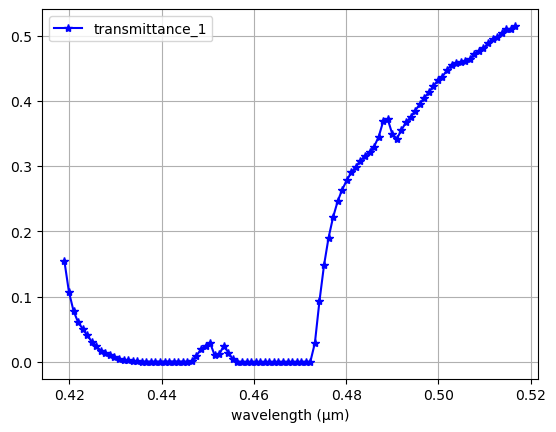

In [25]:
wl = []
Ts_1 = []
a=0.775
for i in range(nfreq):
    wl = np.append(wl,1/flux_freq[i])
    Ts_1 = np.append(Ts_1,phc_tran_flux_2[i]/phc_tran_flux_1[i])
plt.grid(True)
plt.plot(1/wl*a, Ts_1, "b*-", label="transmittance_1")
#plt.xlim(min(wl),max(wl))
plt.xlabel("wavelength (μm)")
plt.legend(loc="best")
plt.savefig(args.name)
plt.show()